In [1]:
import sys, os
sys.path.insert(0, '/data1/home/rocks/discrete_elasticity_v2/')
sys.path.insert(0, '/data1/home/rocks/discrete_elasticity_v2/python_src/')

import numpy as np
import numpy.random as rand
import scipy as sp
import gzip
import cPickle as pickle
import itertools as it
import portalocker

import mech_network_solver as mns
import network as nw
import tuning_algs as talgs


import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns

%matplotlib inline

sns.set(color_codes=True)
sns.set_context('poster', font_scale=1.75)
sns.set_palette("hls", 8)
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})


Loading Mechanical Network Deformation Solver Module


In [18]:
NN = 64
eta = 1e-1
NTS = 128
DIM = 2
Lp = -1.0
irec = 0


nw_label = "network_periodic_jammed/network_N{:05d}_Lp{:.2f}/network_irec{:04d}".format(NN, Lp, irec)

with gzip.open("/data1/home/rocks/data/{:}.pklz".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network']    

NF = 1

edgei = net.edgei
edgej = net.edgej


inodesi = [[] for t in range(NF)]
inodesj = [[] for t in range(NF)]

onodesi = [[] for t in range(NF)]
onodesj = [[] for t in range(NF)]

edge = range(net.NE)

rand.shuffle(edge)

b = edge.pop()

inodesi[0].append(edgei[b])
inodesj[0].append(edgej[b])

for i in range(NTS):
    b = edge.pop()

    onodesi[0].append(edgei[b])
    onodesj[0].append(edgej[b])


print "inodes", inodesi, inodesj

print "onodes", onodesi, onodesj

isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 

istrain = [[] for t in range(NF)]
istrain[0].append(1.0)


osvec = [[] for t in range(NF)]
ostrain = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 

        r = rand.randint(2)
        ostrain[t].append((2*r-1) * eta)

pert = []
meas = []
for t in range(NF):
    pert.append(talgs.Perturb())
    pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain[t], isvec[t])

    meas.append(talgs.Measure())
    meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], osvec[t])

obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain))    


K_init = np.ones(net.NE, float) / net.eq_length

tuner = talgs.TuneContLin(net, pert, meas, obj_func, K_init, alg='LBFGSB')

data = tuner.tune()

inodes [[12]] [[34]]
onodes [[4, 5, 35, 38, 17, 18, 35, 45, 9, 0, 23, 30, 55, 47, 25, 19, 61, 5, 36, 46, 7, 57, 26, 10, 21, 55, 28, 60, 29, 1, 12, 58, 30, 46, 42, 13, 24, 4, 11, 42, 57, 17, 22, 0, 60, 45, 59, 33, 20, 38, 41, 56, 24, 44, 26, 8, 18, 28, 4, 6, 3, 15, 5, 2, 22, 39, 20, 30, 27, 34, 47, 48, 23, 47, 34, 23, 50, 37, 33, 9, 14, 10, 21, 51, 15, 17, 55, 61, 27, 6, 11, 19, 33, 14, 15, 11, 29, 23, 16, 3, 26, 19, 35, 16, 5, 47, 28, 56, 41, 52, 19, 15, 6, 60, 13, 9, 14, 28, 7, 24, 10, 58, 58, 21, 22, 7, 17, 8]] [[44, 40, 58, 31, 34, 45, 37, 57, 62, 28, 53, 36, 46, 38, 48, 32, 54, 10, 53, 52, 50, 12, 51, 39, 62, 41, 31, 53, 59, 38, 27, 1, 38, 0, 44, 45, 62, 51, 42, 8, 27, 54, 33, 43, 56, 48, 50, 41, 32, 52, 43, 53, 48, 46, 30, 59, 48, 39, 29, 19, 14, 60, 39, 5, 44, 40, 50, 51, 50, 39, 31, 62, 36, 1, 43, 61, 54, 42, 18, 49, 33, 49, 25, 59, 56, 39, 43, 49, 54, 20, 35, 24, 55, 25, 35, 37, 44, 30, 40, 47, 52, 56, 63, 25, 49, 16, 40, 62, 45, 31, 62, 32, 57, 36, 12, 56, 63, 34, 37, 45, 54, 

In [2]:
active_mask = [ 0 -1  0  1  0  0  1 -1  0  0 -1  0  0 -1  1 -1  1  0  0 -1  0]

SyntaxError: invalid syntax (<ipython-input-2-c3513bfa0831>, line 1)

8.65084177006e+13 0.865084177006
[1.0498742636666898] [14.72047859283811]


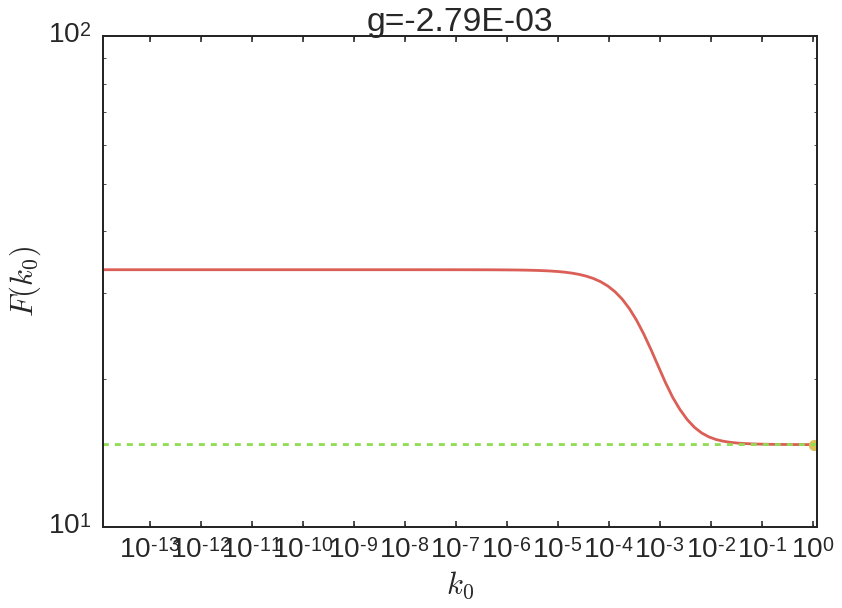

1e+14 1.0
[1.1497229088876662] [14.72047859283811]


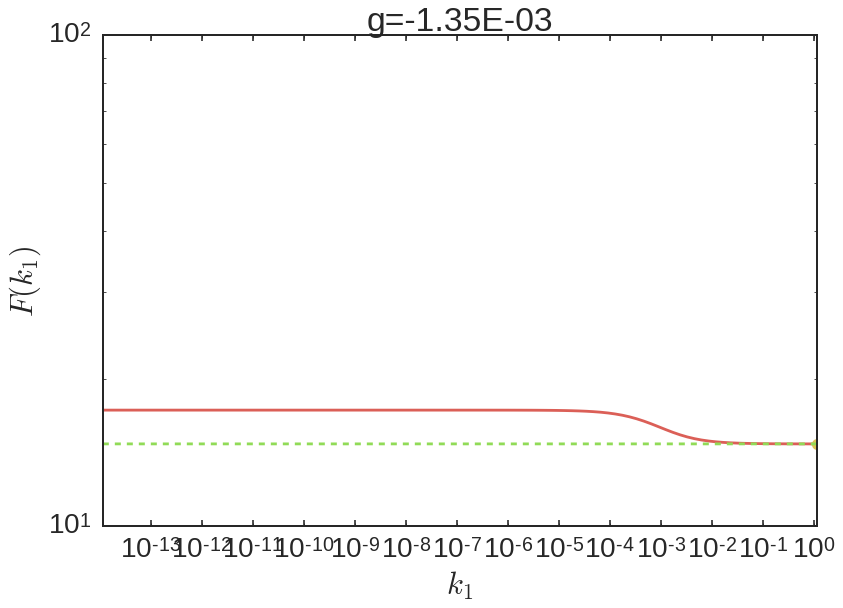

1e+14 1.0
[1.103779095775322] [14.72047859283811]


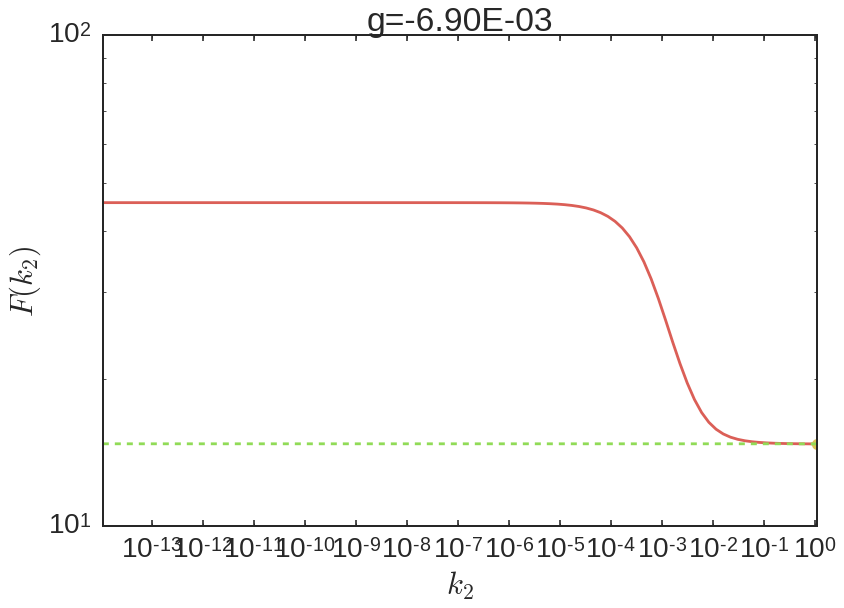

456571583318.0 0.00456571583318
[0.0047211139917125921] [14.72047859283811]


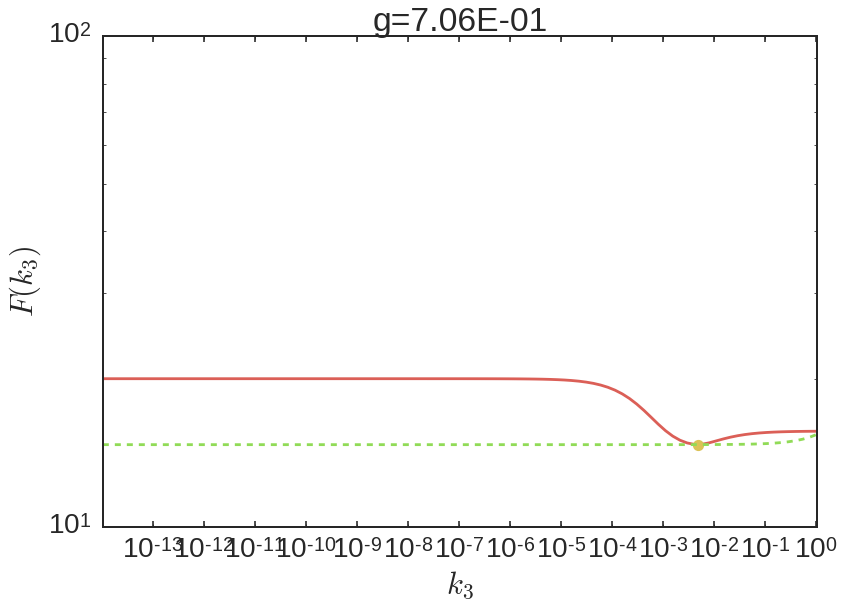

9.16861179601e+13 0.916861179601
[1.0497010922314844] [14.72047859283811]


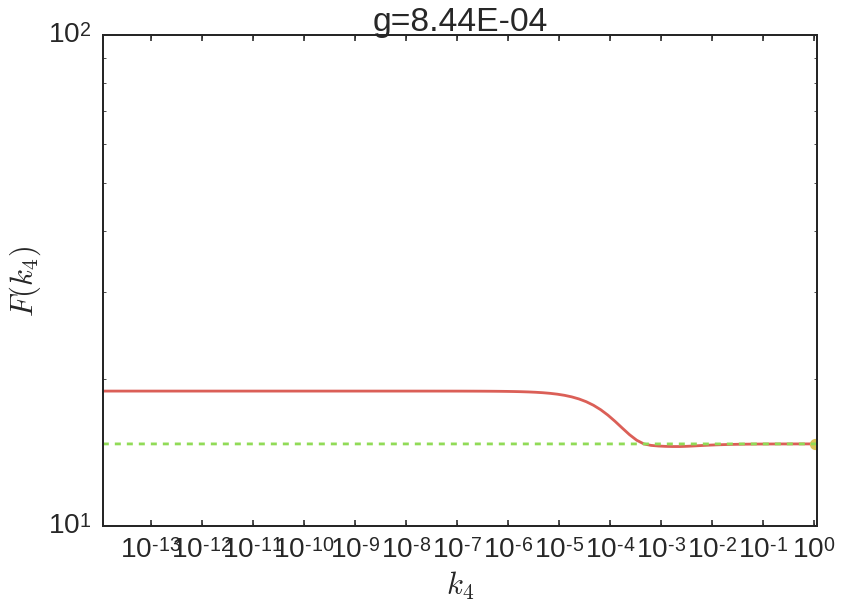

1e+14 1.0
[1.1957013765874132] [14.72047859283811]


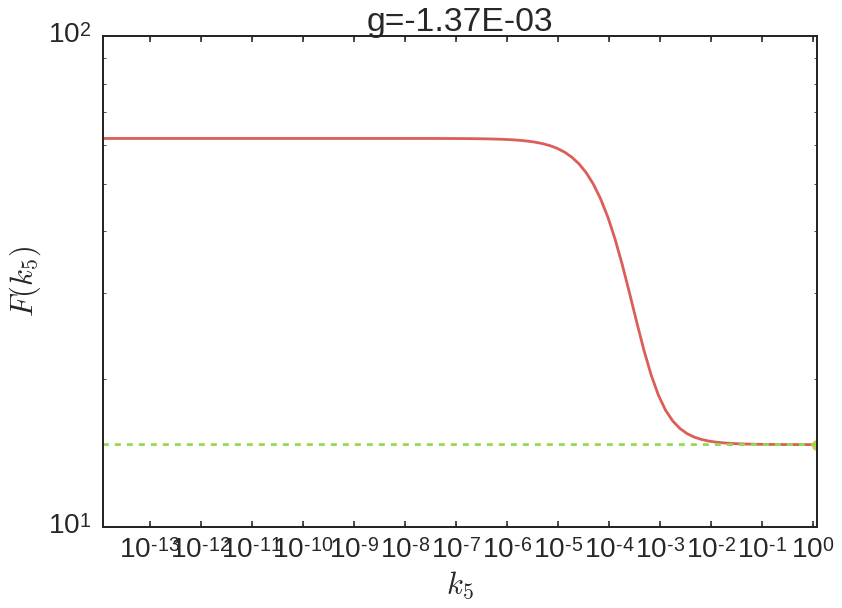

9.79635896021e+13 0.979635896021
[1.1058761126217591] [14.72047859283811]


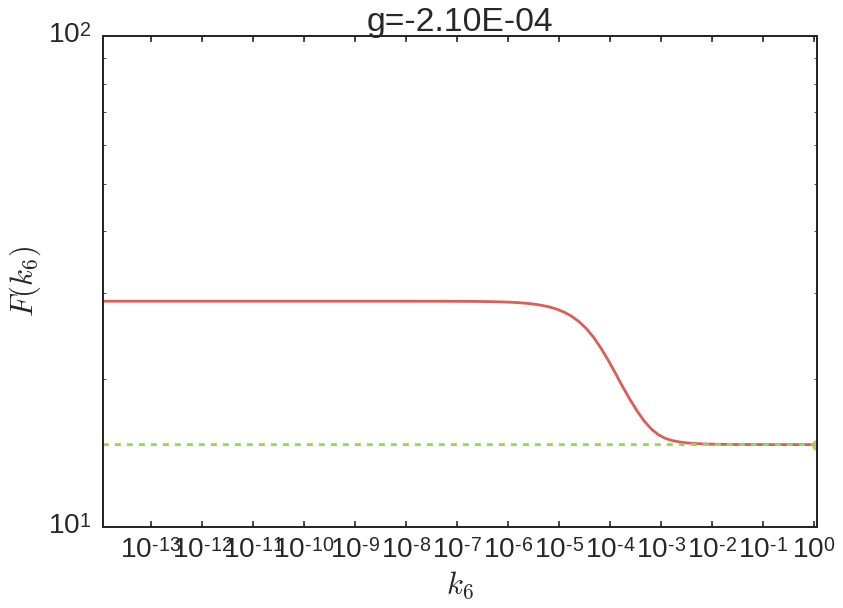

9.81683694265e+13 0.981683694265
[1.1355288144823565] [14.72047859283811]


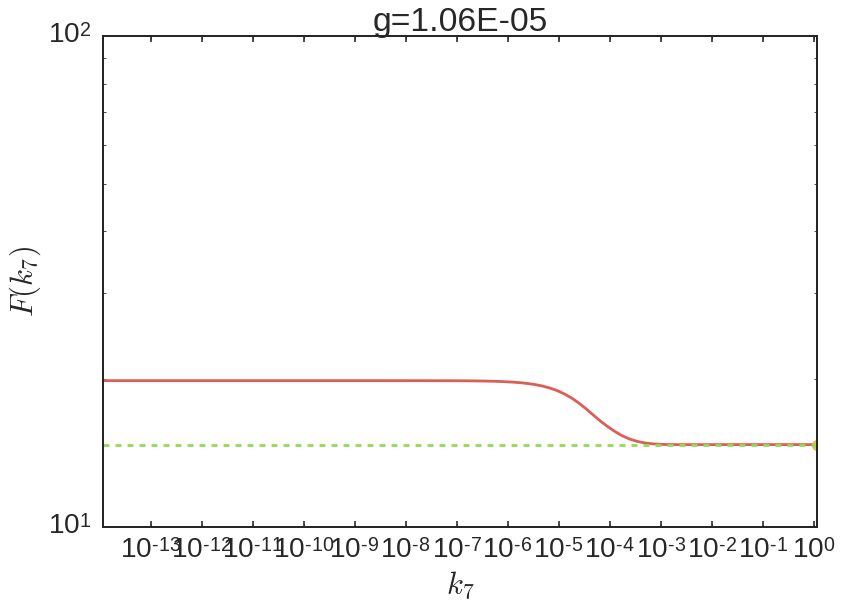

241790957.261 2.41790957261e-06
[2.7019360316355524e-06] [14.72047859283811]


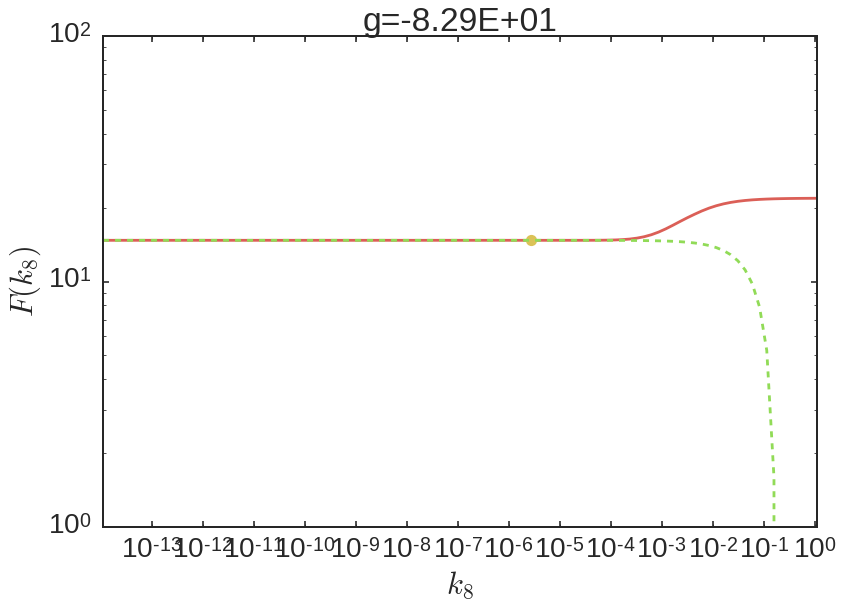

120676634370.0 0.0012067663437
[0.0013265176119402196] [14.72047859283811]


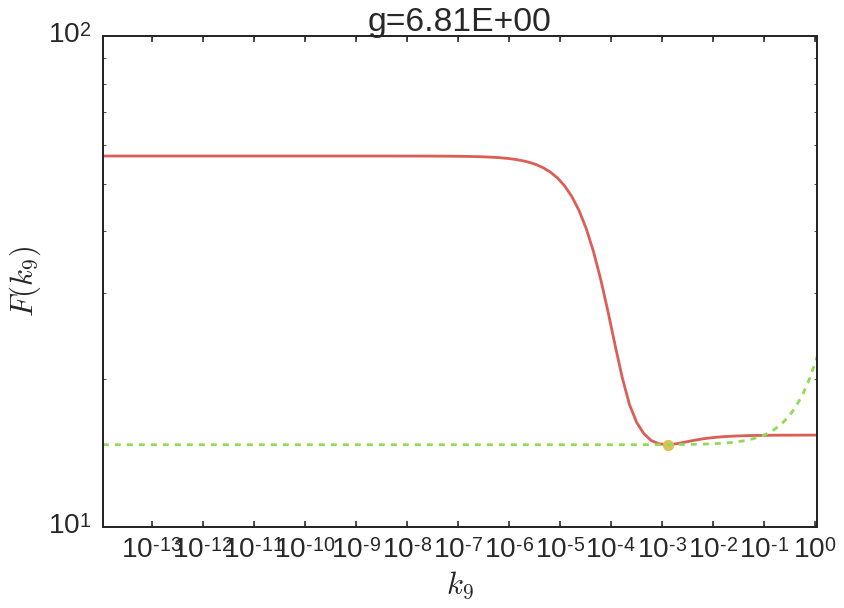

6.1927214692e+12 0.061927214692
[0.067905716746738926] [14.72047859283811]


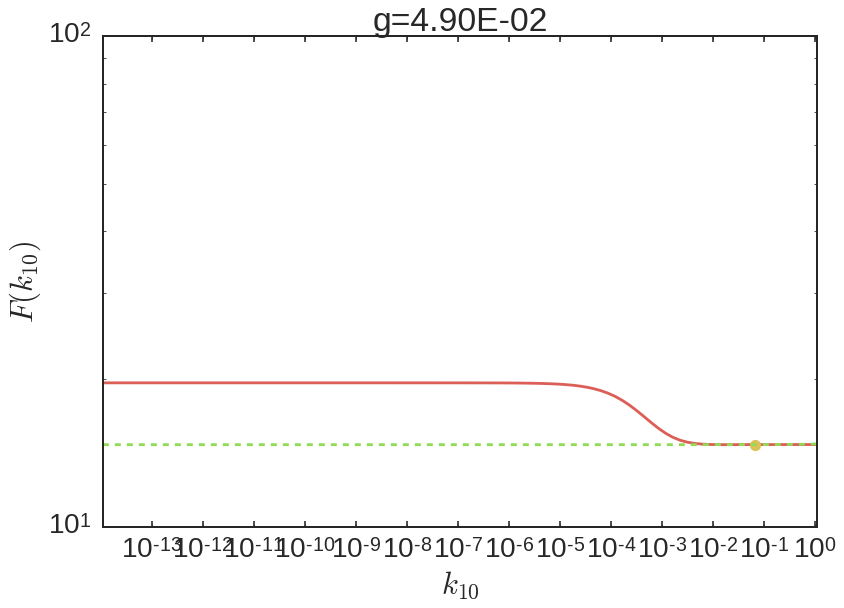

9.91864666055e+13 0.991864666055
[1.0208887215681466] [14.72047859283811]


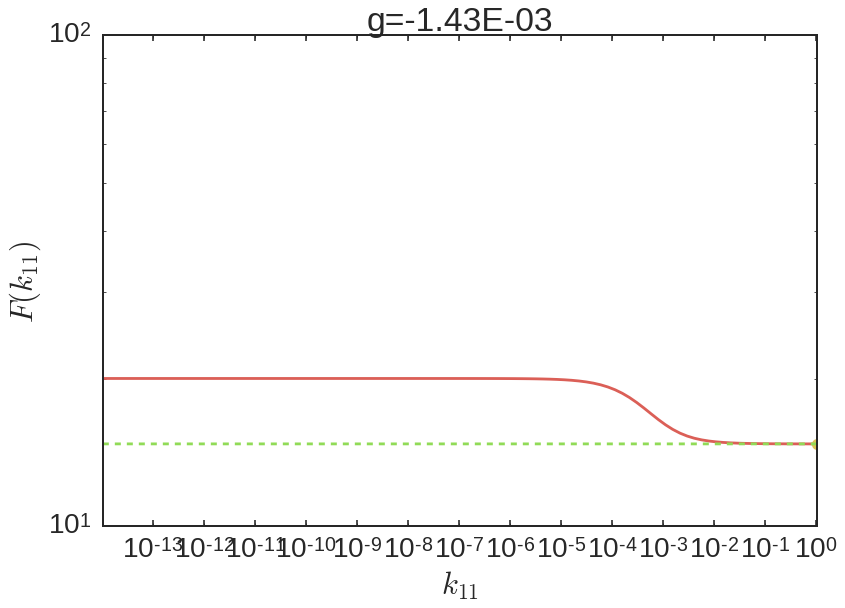

132722764048.0 0.00132722764048
[0.0013844468291508143] [14.72047859283811]


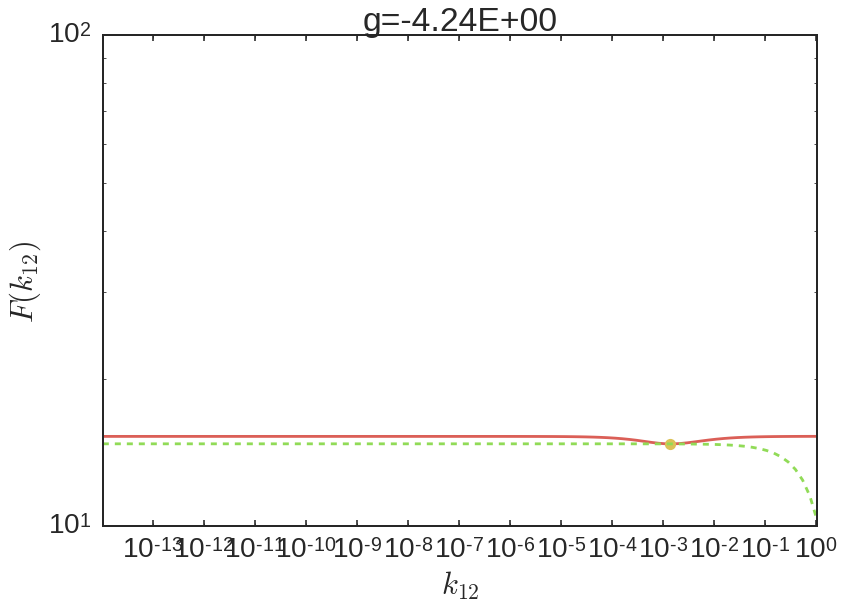

1e+14 1.0
[1.0376681600184661] [14.72047859283811]


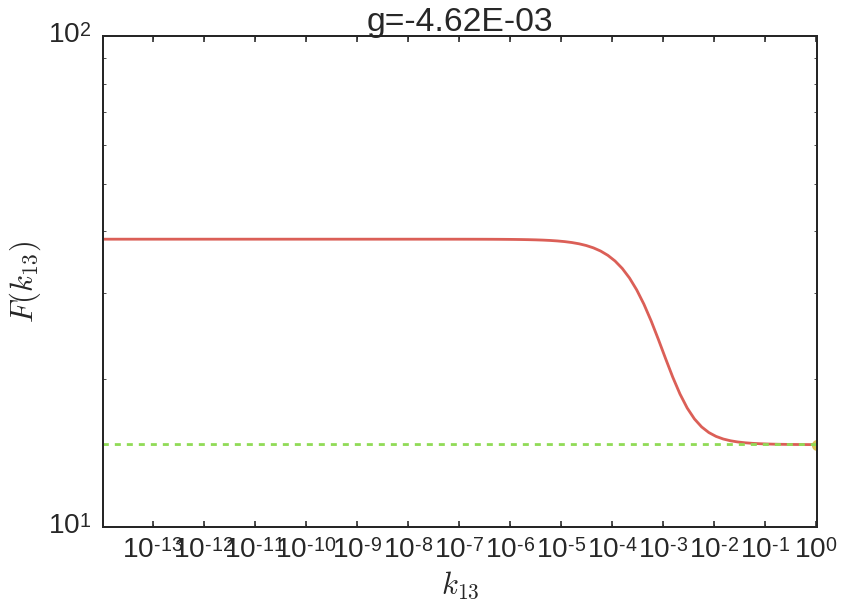

1.08567568902e+12 0.0108567568902
[0.011754324302148726] [14.72047859283811]


KeyboardInterrupt: 

In [8]:
f0 = tuner.func(data['K'])
grad = tuner.grad(data['K'])

for b in range(net.NE):
    K = np.copy(data['K'])
    
    f = []
    
    k0 = K[b]
    
    print k0 / (1e-14 / net.eq_length[b]), k0 / (1e0 / net.eq_length[b])
    
    print [k0], [f0]

    for k in np.logspace(-14.0, 0.0, 100):
        K[b] = k / net.eq_length[b]
    
        eff = tuner.func(K)
    
        f.append(eff)
        
    fig, ax = plt.subplots(1,1)
    ax.set_title("g={1:.2E}".format(b, grad[b]))
    
    ax.plot(np.logspace(-14.0, 0.0, 100)/ net.eq_length[b], f)
    ax.plot([k0], [f0], "o")
    ax.plot(np.logspace(-14.0, 0.0, 100)/ net.eq_length[b], 
            grad[b] * (np.logspace(-14.0, 0.0, 100)/ net.eq_length[b] - k0) + f0, '--')
    
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel("$k_{{{}}}$".format(b))
    ax.set_ylabel("$F(k_{{{}}})$".format(b))
    
    ax.set_xlim(1e-14/net.eq_length[b], 1e0/net.eq_length[b])
    
    plt.show()

[2.7019360316355524e-06] [14.72047859283811]


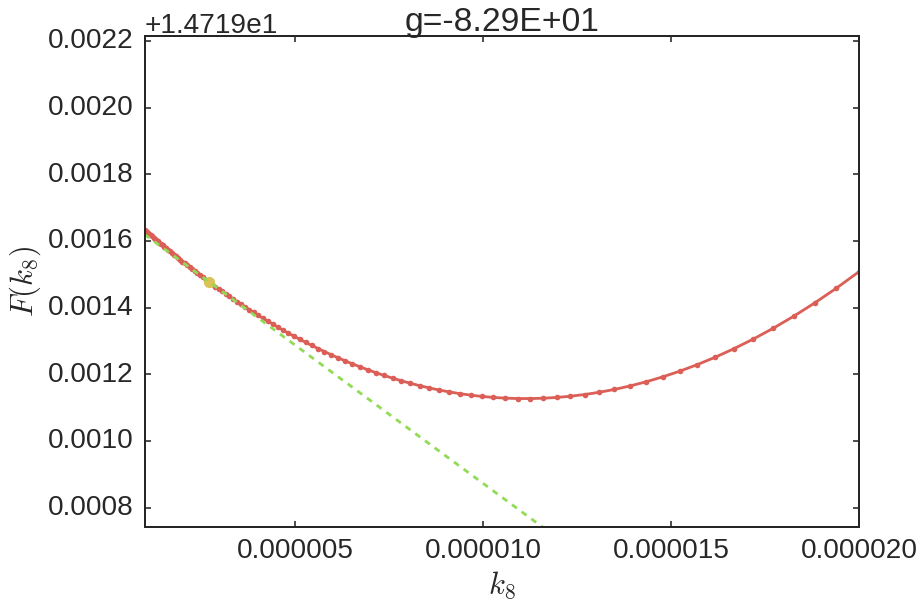

In [17]:
f0 = tuner.func(data['K'])
grad = tuner.grad(data['K'])


K = np.copy(data['K'])
    
f = []

b = 8

k0 = K[b]

print [k0], [f0]

kmin = 1e-6
kmax = 2e-5

krange = np.logspace(np.log10(kmin), np.log10(kmax), 100)

for k in krange:
    K[b] = k

    func = tuner.func(K)

    f.append(func)

fig, ax = plt.subplots(1,1)
ax.set_title("g={1:.2E}".format(b, grad[b]))

ax.plot(krange, f, '.-')
ax.plot([k0], [f0], "o")
ax.plot(krange, 
        grad[b] * (krange - k0) + f0, '--')


# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel("$k_{{{}}}$".format(b))
ax.set_ylabel("$F(k_{{{}}})$".format(b))

ax.set_xlim(kmin, kmax)
ax.set_ylim(0.99995*f0, 1.00005*f0)

plt.show()